In [117]:
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spike2ca import spike2ca, approxDelayConv
%matplotlib notebook

In [2]:
# Test approximate convolution

# decay_tau = 1
# decay_t = np.arange(0, 6 * decay_tau, 0.1)
# decay_x = np.exp(-decay_t / decay_tau)

# fakeSpikes = (np.random.uniform(0, 1, 1000) > 0.99).astype(int)
# convSign = np.convolve(decay_x, fakeSpikes)[:1000]
# approxConv = approxDelayConv(fakeSpikes, decay_tau, 0.1)

# plt.figure()
# plt.plot(fakeSpikes)
# plt.plot(convSign * 0.5)
# plt.plot(approxConv * 0.5)

In [118]:
# Regenerate all file names
VERSION_LST = [1, 1, 2, 3]
NREG_LST = [3,5,5,5]
GEOM_LST = [
    [(0, 1), (1, 2)],
    [(0, 1), (1, 2), (2, 3), (3, 4), (4, 1), (0, 3)],
    [(0, 1), (1, 2), (3, 1), (4, 2)],
    [(0, 1), (1, 2), (2, 0), (0, 3), (3, 2), (3, 4), (4, 1)],
]

WSCALE_LST = [2.0, 4.0, 6.0]
SYND_LST = [50.0, 200.0, 800.0]
STIM_LST = [(0.0, 0.0), (10.0, 20.0), (10.0, 1.0), (50.0, 20.0), (50.0, 1.0)]

gigaPAramLst = []
gigaNamesLst = []
for i in range(len(VERSION_LST)):
    for W in WSCALE_LST:
        for SYN in SYND_LST:
            for sm, sf in STIM_LST:
                gigaPAramLst += [(VERSION_LST[i], NREG_LST[i], GEOM_LST[i], W, SYN, sm, sf)]
                
                outputName = 'data_V' + str(VERSION_LST[i])
                outputName += '_N' + str(NREG_LST[i])
                outputName += '_W' + str(W)
                outputName += '_W' + str(W)
                outputName += '_DT' + str(SYN)
                outputName += '_SM' + str(sm)
                outputName += '_SF' + str(sf)
                gigaNamesLst += [outputName]

for name in gigaNamesLst:
    print(os.path.isfile(name+'_log.txt'))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False

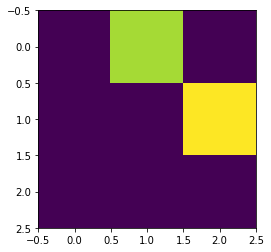

In [4]:
#####################################
#  Extract true connectivity matrix
#####################################

import re

iDataFile = 0
with open(gigaNamesLst[iDataFile] +'_log.txt', "r") as f:
    data = re.split('Ensemble|connection',  f.readlines()[0])
    brackets = {}
    for s in data:
        if len(s) > 0 and s[0] == '(':
            key = tuple(np.array(s[1:s.index(')')].split(', ')).astype(int))
            val = float(s[s.index('trueFunConn') + len('trueFunConn') + 1:])
            brackets[key] = val
            
connM_EnergyTransfer = np.zeros((gigaPAramLst[iDataFile][1], gigaPAramLst[iDataFile][1]))
for k, v in brackets.items():
    connM_EnergyTransfer[k[0]][k[1]] = v
    
connM_EnergyTransfer /= np.sum(connM_EnergyTransfer)
plt.figure()
plt.imshow(connM_EnergyTransfer);

1498


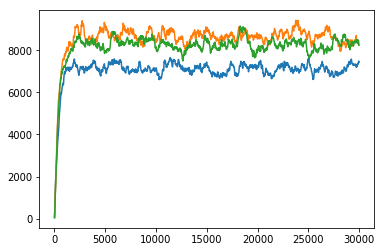

In [110]:
#####################################
#  Extract true connectivity matrix
#####################################

dataFrame = pd.read_table(gigaNamesLst[iDataFile] +'_spikes.txt', delimiter=',', header=0, dtype={0:int, 1:float, 2:int})
populationIdxs = dataFrame.values[:,0].astype(int)
spikeTimes     = dataFrame.values[:,1]
neuronIdxs     = dataFrame.values[:,2].astype(int)

# plt.plot(data[:, 0], data[:, 1], '.')
# plt.show()

# %%time
DT = 0.1         # (ms) Time-discretization of input signal
TAU_CA = 400     # (ms) Delay of CA indicator
GEOM_RANGE = 0.5 # Ratio of neurons that will be 100% visible to the optical detector

MIN_POPUL_IDX = np.min(populationIdxs)
MAX_POPUL_IDX = np.max(populationIdxs)
MIN_TIME = np.min(spikeTimes)  # Important to calculate global over all spikes
MAX_TIME = np.max(spikeTimes)

dataCoarseLst = []

for i in range(MIN_POPUL_IDX, MAX_POPUL_IDX+1):
    populationIdx = populationIdxs == i
    dataFine = spike2ca(spikeTimes[populationIdx], neuronIdxs[populationIdx], DT, TAU_CA, MIN_TIME, MAX_TIME, GEOM_RANGE)
    
    # Generously assume that our recordings will be at 50FPS, so coarsen the data by integrating
    BINSIZE = 20.0
    tCoarse = np.arange(MIN_TIME, MAX_TIME, BINSIZE)
    xCoarse = np.zeros(len(tCoarse))
    for t,x in zip(dataFine[0], dataFine[1]):
        xCoarse[int((t - MIN_TIME) / BINSIZE)] += x / BINSIZE
    
    # Delete last point because it is incomplete due to coarsening    
    tCoarse, xCoarse = tCoarse[:-1], xCoarse[:-1]
    dataCoarseLst += [(tCoarse, xCoarse)]

print(len(dataCoarseLst[0][0]))
    
plt.figure()
for t, x in dataCoarseLst:
    plt.plot(t,x)

0 1 0 0.11806465341446372
0 1 0 0.11652217221334732
0 2 0 0.07490840487848716
0 2 0 0.05879720782097446
1 0 0 0.11806465341446372
1 0 1 0.11763912765637037
1 2 0 0.14719913625817313
1 2 0 0.14609322336822517
2 0 14 0.16098138391112868
2 0 50 0.13212622656671125
2 1 4 0.16041322403502883
2 1 3 0.16042625115087153


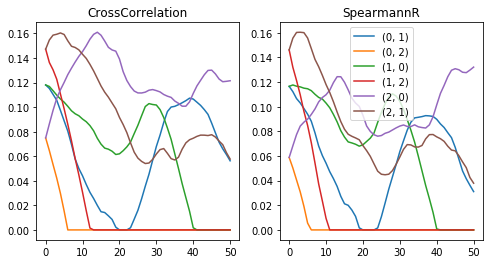

Text(0.5,1,'SpearmannRank')

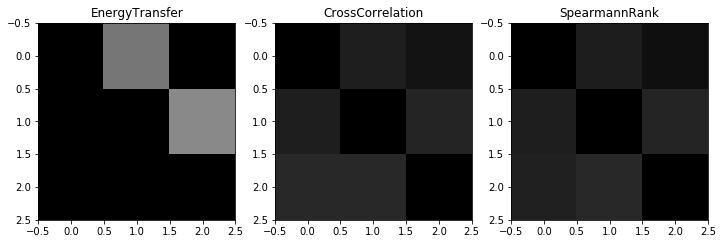

In [116]:
import scipy.stats
###########################################
#  Compute cross-correlation connectivity
###########################################

def corr(x,y):
#     print(len(x), len(y))
    return np.corrcoef(x,y)[0,1]
#     return (x - np.average(x)).dot(y - np.average(y)) / np.std(x) / np.std(y)
#     return np.cov(x,y)[0,1] / np.std(x) / np.std(y)
#     return np.cov(x,y)[0,1] / np.std(x) / np.std(y)

INIT_IGNORE = int(1500 / BINSIZE)  # Ignore first 1.5s because of accumulation
maxDelay = int(1000 / BINSIZE)     # Maximal expected delay for correlations

# plt.figure()
# plt.plot(dataCoarseLst[0][0][INIT_IGNORE:], dataCoarseLst[0][1][INIT_IGNORE:])

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
ax[0].set_title('CrossCorrelation')
ax[1].set_title('SpearmannR')

connM_CrossCorr = np.zeros((gigaPAramLst[iDataFile][1], gigaPAramLst[iDataFile][1]))
connM_SpearmannR = np.zeros((gigaPAramLst[iDataFile][1], gigaPAramLst[iDataFile][1]))
for i in range(gigaPAramLst[iDataFile][1]):
    for j in range(gigaPAramLst[iDataFile][1]):
        if i != j:
            src = dataCoarseLst[i][1][INIT_IGNORE:]
            trg = dataCoarseLst[j][1][INIT_IGNORE:]
            
            corrNorm = np.zeros(maxDelay+1)
            spNorm = np.zeros(maxDelay+1)
            for delay in range(0, maxDelay+1):
                if delay == 0:
                    corrNorm[delay] = corr(src, trg)
                    spNorm[delay] = scipy.stats.spearmanr(src, trg)[0]
                else:
                    corrNorm[delay] = corr(src[:-delay], trg[delay:])
                    spNorm[delay] = scipy.stats.spearmanr(src[:-delay], trg[delay:])[0]
                    
            # In this system, it is unexpected to have negative forwards correlation
            corrNorm[corrNorm < 0] = 0
            spNorm[spNorm < 0] = 0
    
            connM_CrossCorr[i, j] = np.max(corrNorm)# / np.average(corrNorm)
            connM_SpearmannR[i, j] = np.max(spNorm)# / np.average(corrNorm)
            print(i, j, np.argmax(corrNorm), connM_CrossCorr[i, j])
            print(i, j, np.argmax(spNorm), connM_SpearmannR[i, j])
            
            ax[0].plot(corrNorm, label=str((i, j)))
            ax[1].plot(spNorm, label=str((i, j)))
            
plt.legend()
plt.show()

            
fig, ax = plt.subplots(ncols=3, figsize=(12,4))
plt1 = ax[0].imshow(connM_EnergyTransfer, vmin=0, vmax=1, cmap='gray')
ax[0].set_title('EnergyTransfer')
plt2 = ax[1].imshow(connM_CrossCorr, vmin=0, vmax=1, cmap='gray')
ax[1].set_title('CrossCorrelation')
plt3 = ax[2].imshow(connM_SpearmannR, vmin=0, vmax=1, cmap='gray')
ax[2].set_title('SpearmannRank')
# plt.close()
